In [7]:
# Installations
!pip install -q torch torchvision pandas

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from tqdm.auto import tqdm

# For plots
%matplotlib inline

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


Using device: cuda


In [8]:
# Training data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])

# Load base training dataset with NO transform yet
base_train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=None  # we'll add transforms in a wrapper
)

# Test dataset
test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)

# Train/validation split
num_train = len(base_train_dataset)
val_size = int(0.1 * num_train)
train_size = num_train - val_size

indices = np.random.permutation(num_train)
val_indices = indices[:val_size]
train_indices = indices[val_size:]

class CIFAR10Subset(Dataset):
    """
    A thin wrapper to:
    - select a subset of indices from a base CIFAR-10 dataset
    - apply a given transform to the images
    """
    def __init__(self, base_dataset, indices, transform=None):
        self.base_dataset = base_dataset
        self.indices = list(indices)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        base_idx = self.indices[idx]
        img, label = self.base_dataset[base_idx]  # img is PIL image
        if self.transform is not None:
            img = self.transform(img)
        return img, label

# Create train/val subsets that share the same data but use different transforms
train_dataset = CIFAR10Subset(base_train_dataset, train_indices, transform=train_transform)
val_dataset   = CIFAR10Subset(base_train_dataset, val_indices,   transform=test_transform)

from torch.utils.data import DataLoader

def make_dataloaders(batch_size=128):
    # Avoids multiprocessing issues
    num_workers = 0

    pin_memory = (device.type == "cuda")

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    return train_loader, val_loader, test_loader

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")


Train size: 45000, Val size: 5000, Test size: 10000


In [3]:
# Simple and Deep CNN
class SimpleCNN(nn.Module):
    """
    A small CNN for CIFAR-10:
    - 2 convolutional layers
    - 2 fully-connected layers
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [B, 32, 32, 32]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                             # [B, 32, 16, 16]
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # [B, 64, 16, 16]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)                              # [B, 64, 8, 8]
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


class DeeperCNN(nn.Module):
    """
    A deeper CNN with:
    - 3 convolutional blocks
    - BatchNorm
    - Dropout for regularization
    """
    def __init__(self, num_classes=10, dropout_p=0.5):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_p),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [9]:
# Training and evaluations
def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct / total

def train_one_epoch(model, optimizer, train_loader, criterion, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    total = 0

    for images, labels in tqdm(train_loader, leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        running_loss += loss.item() * batch_size
        running_acc += accuracy_from_logits(outputs, labels) * batch_size
        total += batch_size

    epoch_loss = running_loss / total
    epoch_acc = running_acc / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    total = 0

    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        batch_size = labels.size(0)
        running_loss += loss.item() * batch_size
        running_acc += accuracy_from_logits(outputs, labels) * batch_size
        total += batch_size

    epoch_loss = running_loss / total
    epoch_acc = running_acc / total
    return epoch_loss, epoch_acc

def create_model(model_name):
    if model_name == "SimpleCNN":
        return SimpleCNN(num_classes=10)
    elif model_name == "DeeperCNN":
        return DeeperCNN(num_classes=10, dropout_p=0.5)
    else:
        raise ValueError(f"Unknown model_name: {model_name}")

def create_optimizer(optimizer_name, model_parameters, lr, weight_decay=0.0, momentum=0.9):
    if optimizer_name == "SGD":
        return optim.SGD(model_parameters, lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == "Adam":
        return optim.Adam(model_parameters, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer_name: {optimizer_name}")

def create_scheduler(scheduler_name, optimizer, step_size=10, gamma=0.1):
    if scheduler_name is None or scheduler_name.lower() == "none":
        return None
    elif scheduler_name == "StepLR":
        return optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    else:
        raise ValueError(f"Unknown scheduler_name: {scheduler_name}")

def run_experiment(config):
    """
    config: dict with keys:
      - name
      - model_name
      - optimizer_name
      - lr
      - batch_size
      - weight_decay
      - scheduler_name
      - num_epochs
    """
    print("=" * 80)
    print(f"Starting experiment: {config['name']}")
    print(config)

    # Data loaders
    train_loader, val_loader, test_loader = make_dataloaders(batch_size=config["batch_size"])

    # Model, loss, optimizer, scheduler
    model = create_model(config["model_name"]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = create_optimizer(
        optimizer_name=config["optimizer_name"],
        model_parameters=model.parameters(),
        lr=config["lr"],
        weight_decay=config.get("weight_decay", 0.0),
        momentum=config.get("momentum", 0.9)
    )
    scheduler = create_scheduler(
        scheduler_name=config.get("scheduler_name", None),
        optimizer=optimizer,
        step_size=config.get("step_size", 10),
        gamma=config.get("gamma", 0.1)
    )

    num_epochs = config["num_epochs"]

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    best_val_acc = 0.0
    best_epoch = -1

    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")

        train_loss, train_acc = train_one_epoch(
            model=model,
            optimizer=optimizer,
            train_loader=train_loader,
            criterion=criterion,
            device=device
        )

        val_loss, val_acc = evaluate(
            model=model,
            data_loader=val_loader,
            criterion=criterion,
            device=device
        )

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if scheduler is not None:
            scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
        print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc*100:.2f}%")

    # Final test evaluation
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"\nFinal Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")
    print(f"Best Val Acc: {best_val_acc*100:.2f}% at epoch {best_epoch+1}")

    result_summary = {
        "experiment_name": config["name"],
        "model": config["model_name"],
        "optimizer": config["optimizer_name"],
        "batch_size": config["batch_size"],
        "lr": config["lr"],
        "weight_decay": config.get("weight_decay", 0.0),
        "scheduler": config.get("scheduler_name", "none"),
        "num_epochs": num_epochs,
        "best_val_acc": best_val_acc,
        "test_acc": test_acc,
    }

    return result_summary, history

def plot_learning_curves(history, title="Learning Curves"):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"],   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title + " - Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"],   label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title + " - Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [14]:
# Hyperparameters
NUM_EPOCHS = 15

experiments = [
    {
        "name": "SimpleCNN_SGD_bs128_nosched",
        "model_name": "SimpleCNN",
        "optimizer_name": "SGD",
        "lr": 0.01,
        "batch_size": 128,
        "weight_decay": 0.0,
        "scheduler_name": None,
        "num_epochs": NUM_EPOCHS,
    },
    {
        "name": "SimpleCNN_SGD_wd5e-4_stepLR",
        "model_name": "SimpleCNN",
        "optimizer_name": "SGD",
        "lr": 0.01,
        "batch_size": 128,
        "weight_decay": 5e-4,
        "scheduler_name": "StepLR",
        "step_size": 3,
        "gamma": 0.5,
        "num_epochs": NUM_EPOCHS,
    },
    {
        "name": "SimpleCNN_Adam_bs64",
        "model_name": "SimpleCNN",
        "optimizer_name": "Adam",
        "lr": 0.001,
        "batch_size": 64,
        "weight_decay": 0.0,
        "scheduler_name": None,
        "num_epochs": NUM_EPOCHS,
    },
    {
        "name": "DeeperCNN_Adam_bs128_wd5e-4_stepLR",
        "model_name": "DeeperCNN",
        "optimizer_name": "Adam",
        "lr": 0.001,
        "batch_size": 128,
        "weight_decay": 5e-4,
        "scheduler_name": "StepLR",
        "step_size": 3,
        "gamma": 0.5,
        "num_epochs": NUM_EPOCHS,
    },
]


In [15]:
# Experiment and results
all_results = []
all_histories = {}

for config in experiments:
    result_summary, history = run_experiment(config)
    all_results.append(result_summary)
    all_histories[config["name"]] = history

# Convert results for comparison
results_df = pd.DataFrame(all_results)
results_df["best_val_acc_%"] = results_df["best_val_acc"] * 100
results_df["test_acc_%"] = results_df["test_acc"] * 100

print("\n===== Summary of Experiments =====")
display(results_df[[
    "experiment_name",
    "model",
    "optimizer",
    "batch_size",
    "lr",
    "weight_decay",
    "scheduler",
    "num_epochs",
    "best_val_acc_%",
    "test_acc_%"
]])

Starting experiment: SimpleCNN_SGD_bs128_nosched
{'name': 'SimpleCNN_SGD_bs128_nosched', 'model_name': 'SimpleCNN', 'optimizer_name': 'SGD', 'lr': 0.01, 'batch_size': 128, 'weight_decay': 0.0, 'scheduler_name': None, 'num_epochs': 15}

Epoch [1/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 1.7592, Train Acc: 35.31%
Val   Loss: 1.5344, Val   Acc: 44.58%

Epoch [2/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 1.4109, Train Acc: 48.65%
Val   Loss: 1.2124, Val   Acc: 54.86%

Epoch [3/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 1.2366, Train Acc: 55.25%
Val   Loss: 1.0732, Val   Acc: 61.80%

Epoch [4/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 1.1164, Train Acc: 59.85%
Val   Loss: 0.9724, Val   Acc: 64.92%

Epoch [5/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 1.0330, Train Acc: 63.30%
Val   Loss: 0.9156, Val   Acc: 66.56%

Epoch [6/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.9661, Train Acc: 65.80%
Val   Loss: 0.8789, Val   Acc: 68.88%

Epoch [7/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.9163, Train Acc: 67.41%
Val   Loss: 0.8282, Val   Acc: 70.00%

Epoch [8/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.8690, Train Acc: 69.51%
Val   Loss: 0.8108, Val   Acc: 70.52%

Epoch [9/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.8348, Train Acc: 70.64%
Val   Loss: 0.7767, Val   Acc: 72.52%

Epoch [10/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.8139, Train Acc: 71.07%
Val   Loss: 0.7656, Val   Acc: 73.32%

Epoch [11/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.7818, Train Acc: 72.30%
Val   Loss: 0.7598, Val   Acc: 73.58%

Epoch [12/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.7561, Train Acc: 73.48%
Val   Loss: 0.7330, Val   Acc: 74.34%

Epoch [13/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.7382, Train Acc: 74.18%
Val   Loss: 0.6911, Val   Acc: 76.04%

Epoch [14/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.7096, Train Acc: 75.24%
Val   Loss: 0.6982, Val   Acc: 75.60%

Epoch [15/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.6950, Train Acc: 75.74%
Val   Loss: 0.7158, Val   Acc: 74.82%

Final Test Loss: 0.7315, Test Acc: 75.02%
Best Val Acc: 76.04% at epoch 13
Starting experiment: SimpleCNN_SGD_wd5e-4_stepLR
{'name': 'SimpleCNN_SGD_wd5e-4_stepLR', 'model_name': 'SimpleCNN', 'optimizer_name': 'SGD', 'lr': 0.01, 'batch_size': 128, 'weight_decay': 0.0005, 'scheduler_name': 'StepLR', 'step_size': 3, 'gamma': 0.5, 'num_epochs': 15}

Epoch [1/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 1.7560, Train Acc: 35.77%
Val   Loss: 1.4714, Val   Acc: 45.40%

Epoch [2/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 1.4191, Train Acc: 48.65%
Val   Loss: 1.2319, Val   Acc: 55.08%

Epoch [3/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 1.2519, Train Acc: 54.97%
Val   Loss: 1.1243, Val   Acc: 59.88%

Epoch [4/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 1.1042, Train Acc: 60.76%
Val   Loss: 1.0296, Val   Acc: 62.80%

Epoch [5/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 1.0407, Train Acc: 63.16%
Val   Loss: 0.9391, Val   Acc: 66.66%

Epoch [6/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.9988, Train Acc: 64.66%
Val   Loss: 0.8983, Val   Acc: 68.84%

Epoch [7/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.9311, Train Acc: 67.16%
Val   Loss: 0.8543, Val   Acc: 70.12%

Epoch [8/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.9094, Train Acc: 68.06%
Val   Loss: 0.8620, Val   Acc: 68.70%

Epoch [9/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.8905, Train Acc: 68.80%
Val   Loss: 0.8392, Val   Acc: 70.58%

Epoch [10/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.8565, Train Acc: 70.13%
Val   Loss: 0.8180, Val   Acc: 71.38%

Epoch [11/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.8427, Train Acc: 70.40%
Val   Loss: 0.7980, Val   Acc: 71.80%

Epoch [12/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.8343, Train Acc: 70.61%
Val   Loss: 0.8016, Val   Acc: 71.80%

Epoch [13/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.8132, Train Acc: 71.74%
Val   Loss: 0.7777, Val   Acc: 72.88%

Epoch [14/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.8106, Train Acc: 71.74%
Val   Loss: 0.7778, Val   Acc: 72.92%

Epoch [15/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.8066, Train Acc: 71.86%
Val   Loss: 0.7756, Val   Acc: 72.94%

Final Test Loss: 0.7786, Test Acc: 73.11%
Best Val Acc: 72.94% at epoch 15
Starting experiment: SimpleCNN_Adam_bs64
{'name': 'SimpleCNN_Adam_bs64', 'model_name': 'SimpleCNN', 'optimizer_name': 'Adam', 'lr': 0.001, 'batch_size': 64, 'weight_decay': 0.0, 'scheduler_name': None, 'num_epochs': 15}

Epoch [1/15]


  0%|          | 0/704 [00:00<?, ?it/s]

Train Loss: 1.5200, Train Acc: 44.84%
Val   Loss: 1.1644, Val   Acc: 58.06%

Epoch [2/15]


  0%|          | 0/704 [00:00<?, ?it/s]

Train Loss: 1.1616, Train Acc: 58.37%
Val   Loss: 1.0098, Val   Acc: 62.74%

Epoch [3/15]


  0%|          | 0/704 [00:00<?, ?it/s]

Train Loss: 1.0168, Train Acc: 64.00%
Val   Loss: 0.9130, Val   Acc: 66.90%

Epoch [4/15]


  0%|          | 0/704 [00:00<?, ?it/s]

Train Loss: 0.9437, Train Acc: 66.56%
Val   Loss: 0.8912, Val   Acc: 69.34%

Epoch [5/15]


  0%|          | 0/704 [00:00<?, ?it/s]

Train Loss: 0.8876, Train Acc: 68.73%
Val   Loss: 0.8106, Val   Acc: 71.54%

Epoch [6/15]


  0%|          | 0/704 [00:00<?, ?it/s]

Train Loss: 0.8438, Train Acc: 70.47%
Val   Loss: 0.8144, Val   Acc: 71.60%

Epoch [7/15]


  0%|          | 0/704 [00:00<?, ?it/s]

Train Loss: 0.8089, Train Acc: 71.63%
Val   Loss: 0.7398, Val   Acc: 74.04%

Epoch [8/15]


  0%|          | 0/704 [00:00<?, ?it/s]

Train Loss: 0.7750, Train Acc: 72.80%
Val   Loss: 0.7300, Val   Acc: 74.72%

Epoch [9/15]


  0%|          | 0/704 [00:00<?, ?it/s]

Train Loss: 0.7552, Train Acc: 73.84%
Val   Loss: 0.7619, Val   Acc: 73.70%

Epoch [10/15]


  0%|          | 0/704 [00:00<?, ?it/s]

Train Loss: 0.7366, Train Acc: 74.31%
Val   Loss: 0.7002, Val   Acc: 75.56%

Epoch [11/15]


  0%|          | 0/704 [00:00<?, ?it/s]

Train Loss: 0.7115, Train Acc: 75.00%
Val   Loss: 0.7062, Val   Acc: 75.84%

Epoch [12/15]


  0%|          | 0/704 [00:00<?, ?it/s]

Train Loss: 0.6957, Train Acc: 75.60%
Val   Loss: 0.7038, Val   Acc: 75.00%

Epoch [13/15]


  0%|          | 0/704 [00:00<?, ?it/s]

Train Loss: 0.6847, Train Acc: 75.78%
Val   Loss: 0.6839, Val   Acc: 76.64%

Epoch [14/15]


  0%|          | 0/704 [00:00<?, ?it/s]

Train Loss: 0.6688, Train Acc: 76.61%
Val   Loss: 0.6495, Val   Acc: 77.64%

Epoch [15/15]


  0%|          | 0/704 [00:00<?, ?it/s]

Train Loss: 0.6567, Train Acc: 77.03%
Val   Loss: 0.6767, Val   Acc: 76.58%

Final Test Loss: 0.6892, Test Acc: 76.16%
Best Val Acc: 77.64% at epoch 14
Starting experiment: DeeperCNN_Adam_bs128_wd5e-4_stepLR
{'name': 'DeeperCNN_Adam_bs128_wd5e-4_stepLR', 'model_name': 'DeeperCNN', 'optimizer_name': 'Adam', 'lr': 0.001, 'batch_size': 128, 'weight_decay': 0.0005, 'scheduler_name': 'StepLR', 'step_size': 3, 'gamma': 0.5, 'num_epochs': 15}

Epoch [1/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 1.6224, Train Acc: 40.26%
Val   Loss: 1.3833, Val   Acc: 49.34%

Epoch [2/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 1.2330, Train Acc: 55.58%
Val   Loss: 1.3444, Val   Acc: 54.02%

Epoch [3/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 1.0630, Train Acc: 62.26%
Val   Loss: 0.8822, Val   Acc: 67.36%

Epoch [4/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.8938, Train Acc: 68.60%
Val   Loss: 0.7572, Val   Acc: 72.94%

Epoch [5/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.8270, Train Acc: 71.44%
Val   Loss: 0.7242, Val   Acc: 74.22%

Epoch [6/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.7774, Train Acc: 73.02%
Val   Loss: 0.6832, Val   Acc: 75.36%

Epoch [7/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.6902, Train Acc: 76.23%
Val   Loss: 0.5427, Val   Acc: 80.62%

Epoch [8/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.6502, Train Acc: 77.70%
Val   Loss: 0.6047, Val   Acc: 78.68%

Epoch [9/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.6287, Train Acc: 78.32%
Val   Loss: 0.5615, Val   Acc: 80.14%

Epoch [10/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.5688, Train Acc: 80.60%
Val   Loss: 0.4759, Val   Acc: 83.22%

Epoch [11/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.5461, Train Acc: 81.47%
Val   Loss: 0.4646, Val   Acc: 83.92%

Epoch [12/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.5299, Train Acc: 82.06%
Val   Loss: 0.4396, Val   Acc: 84.60%

Epoch [13/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.5044, Train Acc: 82.92%
Val   Loss: 0.4317, Val   Acc: 84.88%

Epoch [14/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.4877, Train Acc: 83.27%
Val   Loss: 0.4270, Val   Acc: 85.20%

Epoch [15/15]


  0%|          | 0/352 [00:00<?, ?it/s]

Train Loss: 0.4843, Train Acc: 83.57%
Val   Loss: 0.4235, Val   Acc: 85.24%

Final Test Loss: 0.4409, Test Acc: 84.88%
Best Val Acc: 85.24% at epoch 15

===== Summary of Experiments =====


,experiment_name,model,optimizer,batch_size,lr,weight_decay,scheduler,num_epochs,best_val_acc_%,test_acc_%
0,SimpleCNN_SGD_bs128_nosched,SimpleCNN,SGD,128,0.010,0.0000,None,15,76.04,75.02
1,SimpleCNN_SGD_wd5e-4_stepLR,SimpleCNN,SGD,128,0.010,0.0005,StepLR,15,72.94,73.11
2,SimpleCNN_Adam_bs64,SimpleCNN,Adam,64,0.001,0.0000,None,15,77.64,76.16
3,DeeperCNN_Adam_bs128_wd5e-4_stepLR,DeeperCNN,Adam,128,0.001,0.0005,StepLR,15,85.24,84.88


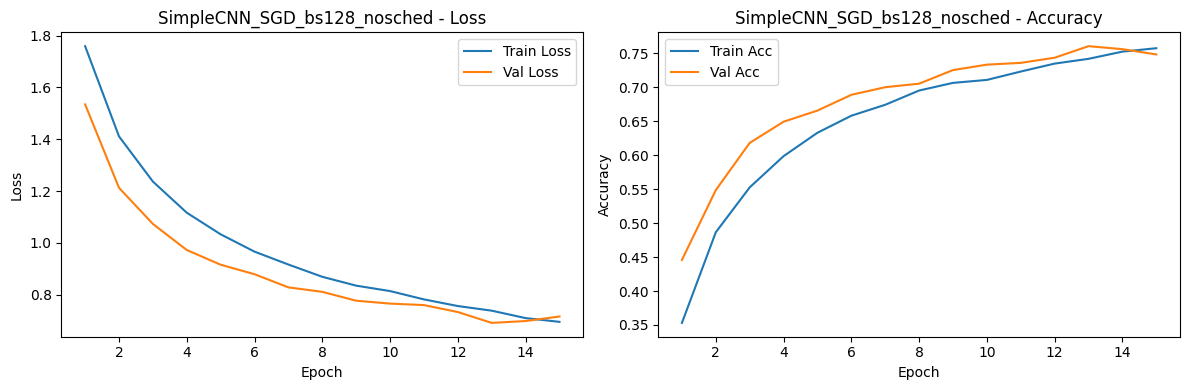

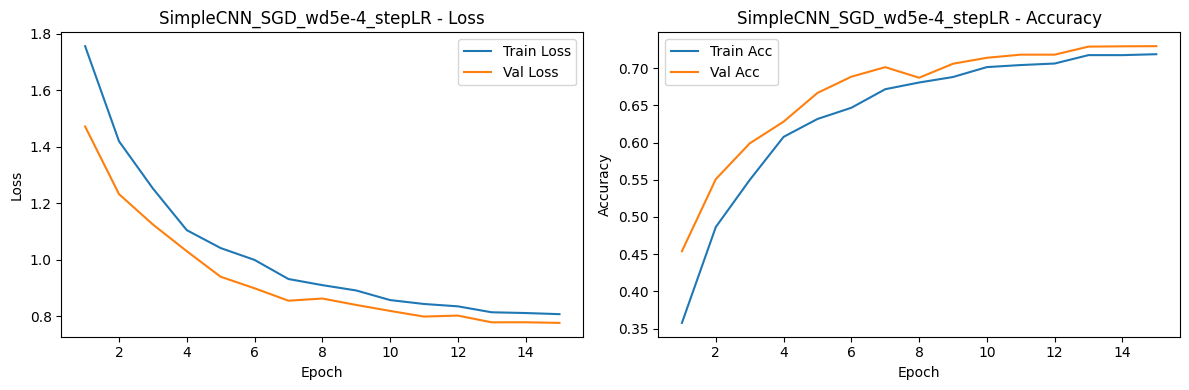

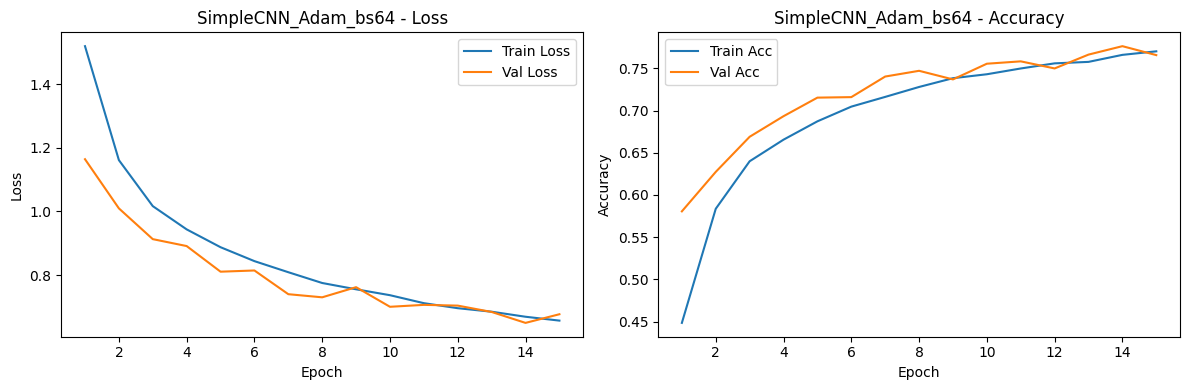

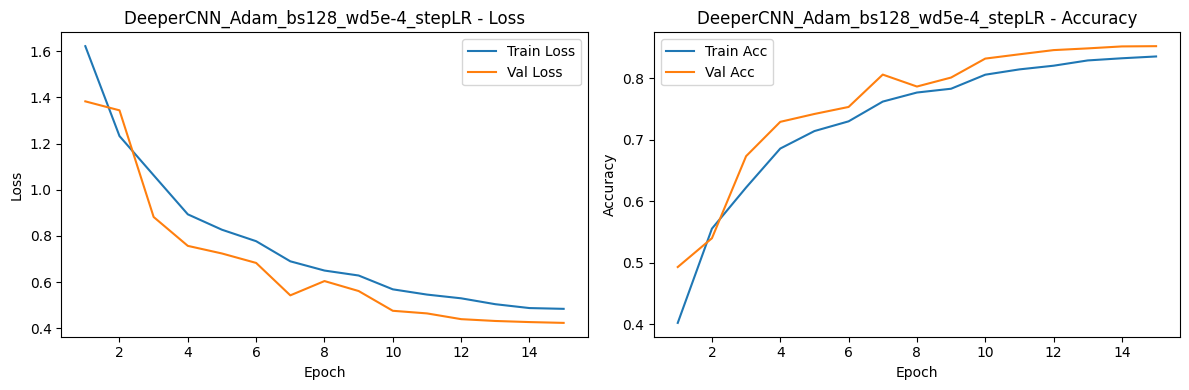

In [16]:
# Plots
for exp_name, hist in all_histories.items():
    plot_learning_curves(hist, title=exp_name)